<a href="https://colab.research.google.com/github/abyanjan/Pytorch-Deep-Learning/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoders

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

**Visualizing Data**

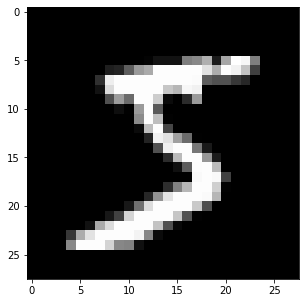

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

##Using Transpose Convolutions for Decoder

In [17]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer(depth from 1 --> 16), 3x3 kernel
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        # conv layer(depth from 16 --> 4), 3x3 kernel
        self.conv2 = nn.Conv2d(16, 4, 3, padding = 1)
        # pooling layer with kernel and stride of 2
        self.pool = nn.MaxPool2d(2,2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # first conv layer
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # second conv layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        ## decode ##
        ## apply ReLu to all hidden layers *except for the output layer
        ## apply a sigmoid to the output layer
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))      
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


**Training**

In [18]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.548484
Epoch: 2 	Training Loss: 0.218367
Epoch: 3 	Training Loss: 0.196834
Epoch: 4 	Training Loss: 0.187124
Epoch: 5 	Training Loss: 0.180724
Epoch: 6 	Training Loss: 0.176847
Epoch: 7 	Training Loss: 0.174473
Epoch: 8 	Training Loss: 0.172680
Epoch: 9 	Training Loss: 0.171174
Epoch: 10 	Training Loss: 0.169956
Epoch: 11 	Training Loss: 0.168978
Epoch: 12 	Training Loss: 0.168149
Epoch: 13 	Training Loss: 0.167389
Epoch: 14 	Training Loss: 0.166691
Epoch: 15 	Training Loss: 0.165942
Epoch: 16 	Training Loss: 0.165155
Epoch: 17 	Training Loss: 0.164490
Epoch: 18 	Training Loss: 0.163943
Epoch: 19 	Training Loss: 0.163460
Epoch: 20 	Training Loss: 0.162946
Epoch: 21 	Training Loss: 0.162194
Epoch: 22 	Training Loss: 0.161361
Epoch: 23 	Training Loss: 0.160763
Epoch: 24 	Training Loss: 0.160262
Epoch: 25 	Training Loss: 0.159854
Epoch: 26 	Training Loss: 0.159496
Epoch: 27 	Training Loss: 0.159196
Epoch: 28 	Training Loss: 0.158933
Epoch: 29 	Training Loss: 0.1

**Evaluation on the test data**

In [25]:
model.eval()

# monitor the loss
test_loss = 0.0

for data in test_loader:
  # _ stands in for labels, here
  images, _ = data
  # forward pass: compute predicted outputs by passing inputs to the model
  outputs = model(images)
  # calculate the loss
  loss = criterion(outputs, images)
  # update test loss
  test_loss += loss.item()*images.size(0)     

# the overall test lost
print(f'\n Final Test Loss: {np.round(test_loss/len(test_loader),4)}')
   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 Final Test Loss: 0.1551


**Visualizing the results**

Below is the plots for some of the test images along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect that tends to happen with transpose layers.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


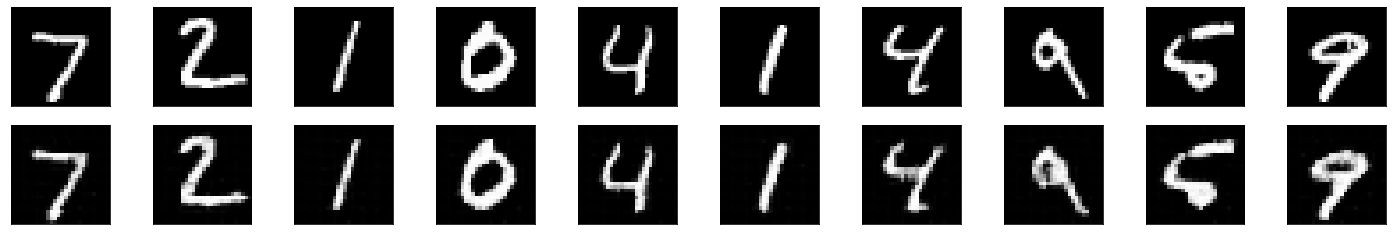

In [27]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
#output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Using Upsampling for Decoder

In [29]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer(depth from 1 --> 16), 3x3 kernel
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        # conv layer(depth from 16 --> 4), 3x3 kernel
        self.conv2 = nn.Conv2d(16, 4, 3, padding = 1)
        # pooling layer with kernel and stride of 2
        self.pool = nn.MaxPool2d(2,2)
        
        ## decoder layers ##
        self.conv3 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # first conv layer
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # second conv layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        ## decode ##
        # upsample followed by conv layer with relu activation
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv3(x))
        # upsample again and apply sigmoid for the final output
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv4(x))      
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


**Training**

In [30]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.318542
Epoch: 2 	Training Loss: 0.149119
Epoch: 3 	Training Loss: 0.132415
Epoch: 4 	Training Loss: 0.124655
Epoch: 5 	Training Loss: 0.119911
Epoch: 6 	Training Loss: 0.116713
Epoch: 7 	Training Loss: 0.114249
Epoch: 8 	Training Loss: 0.112355
Epoch: 9 	Training Loss: 0.110824
Epoch: 10 	Training Loss: 0.109573
Epoch: 11 	Training Loss: 0.108487
Epoch: 12 	Training Loss: 0.107542
Epoch: 13 	Training Loss: 0.106727
Epoch: 14 	Training Loss: 0.106018
Epoch: 15 	Training Loss: 0.105378
Epoch: 16 	Training Loss: 0.104778
Epoch: 17 	Training Loss: 0.104211
Epoch: 18 	Training Loss: 0.103686
Epoch: 19 	Training Loss: 0.103212
Epoch: 20 	Training Loss: 0.102787
Epoch: 21 	Training Loss: 0.102410
Epoch: 22 	Training Loss: 0.102054
Epoch: 23 	Training Loss: 0.101717
Epoch: 24 	Training Loss: 0.101424
Epoch: 25 	Training Loss: 0.101158
Epoch: 26 	Training Loss: 0.100921
Epoch: 27 	Training Loss: 0.100685
Epoch: 28 	Training Loss: 0.100450
Epoch: 29 	Training Loss: 0.1

**Evaluation on the test data**

In [33]:
model.eval()

# monitor the loss
test_loss = 0.0

for data in test_loader:
  # _ stands in for labels, here
  images, _ = data
  # forward pass: compute predicted outputs by passing inputs to the model
  outputs = model(images)
  # calculate the loss
  loss = criterion(outputs, images)
  # update test loss
  test_loss += loss.item()*images.size(0)     

# the overall test lost
print(f'\n Final Test Loss: {test_loss/len(test_loader):.4f}')
   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 Final Test Loss: 0.0996


**Visualizing the reulsts**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


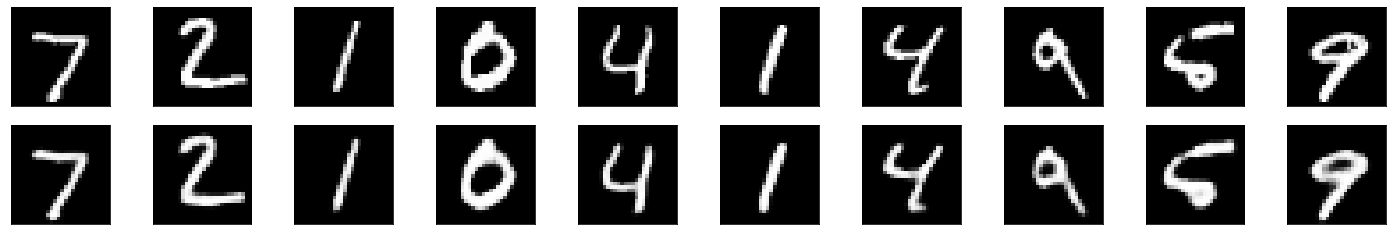

In [34]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
#output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

We have a lower overall test loss with the upsampling method and the reconstructed images also looks more smoother than closed to the original images.